<a href="https://colab.research.google.com/github/Perelius/SandBox/blob/master/Portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optimizing a stock portfolio with python

The objective of this notebook is to show the wide range of resources available in Python to optimize a stock portfolio. 
Python, along with R, are the most used languages in the field of data analysis, so I believe that financial analysts should know the possibilities they offer for projections, sensitivity analysis, valuation automation, optimization, trading systems, etc 



---




**Reference book: **https://www.oreilly.com/library/view/python-for-finance/9781491945360/

For the optimization we used the PyPortfolioOpt library, the documentation is here:

Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info.


Also some code examples were used from : 

Damian Boh : https://github.com/damianboh/portfolio_optimization

Robert Martin: https://github.com/robertmartin8/PyPortfolioOpt



---



Finally for the analysis the following tickers will be used 

'AAPL', 'AXP','BAC','CVX','KO'

These stocks represent 75% of Warren Buffet's portfolio. 

https://www.buffett.online/en/portfolio/


We will build an optimal portfolio with them using different methodologies and then compare them against Warren Buffet's portfolio and the SP500. 


**No theoretical concepts such as sharpe ratio, sortino ratio, efficient frontier, etc. will be discussed in detail. Since what is intended is to present a new tool and how to apply it.**




#Library installation and import

In [ ]:
!pip install PyPortfolioOpt
!pip install plotly
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
import yfinance as yf
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#list of stocks in portfolio
stock_list = ['AAPL', 'AXP','BAC','CVX','KO']
print('stock_list:', stock_list)
data = yf.download(stock_list,  period='10y')
print('data fields downloaded:', set(data.columns.get_level_values(0)))
data.head()
stocks_df = data['Adj Close']

stock_list: ['AAPL', 'AXP', 'BAC', 'CVX', 'KO']
[*********************100%***********************]  5 of 5 completed
data fields downloaded: {'High', 'Adj Close', 'Volume', 'Low', 'Open', 'Close'}


In [ ]:
stocks_df

,AAPL,AXP,BAC,CVX,KO
Date,,,,,
2012-08-27,20.692650,49.757397,6.927107,73.821030,27.884924
2012-08-28,20.665697,49.878716,6.832685,74.230690,27.760729
2012-08-29,20.624969,49.757397,6.867021,73.867264,27.366232
2012-08-30,20.330971,49.540760,6.789766,73.292473,27.132467
2012-08-31,20.372927,50.519970,6.858437,74.105133,27.322399
...,...,...,...,...,...
2022-08-19,171.520004,162.240005,35.480000,157.690002,65.169998
2022-08-22,167.570007,157.699997,34.720001,156.899994,64.199997
2022-08-23,167.229996,157.330002,34.410000,161.990005,64.269997


#EDA

We can observe that the prices of the most volatile and innovative stocks such as Apple and Amex have been the ones that have grown the most in comparison to Coca-Cola and Bank of America. These are more stable.  Chevron is more cyclical.

In [ ]:
fig_price = px.line(stocks_df, title='Price of Individual Stocks')
fig_price.show()

Below we extract very quickly the % of price variation for some basic analysis. With pandas it is very easy to obtain them.

In [ ]:
daily_returns = stocks_df.pct_change().dropna()
daily_returns.head()

,AAPL,AXP,BAC,CVX,KO
Date,,,,,
2012-08-28,-0.001303,0.002438,-0.013631,0.005549,-0.004454
2012-08-29,-0.001971,-0.002432,0.005025,-0.004896,-0.014211
2012-08-30,-0.014255,-0.004354,-0.011250,-0.007781,-0.008542
2012-08-31,0.002064,0.019766,0.010114,0.011088,0.007000
2012-09-04,0.014626,0.005317,0.001252,-0.008381,-0.003209


In [ ]:
fig = px.line(daily_returns[['AAPL', 'AXP','BAC','CVX','KO']], title='Daily Returns')
fig.show()

**The distribution of stock returns follows an approximate normal distribution.**

(-0.1, 0.1)

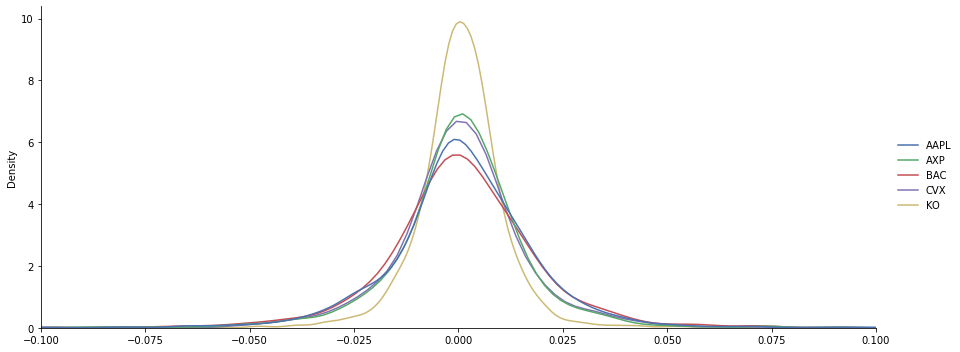

In [ ]:
sns.displot(data=daily_returns[['AAPL', 'AXP','BAC','CVX','KO']], kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

**No. It's not a joke. 100 dollars in Apple shares in last 10 years became 843 dollars. That is a 744% increase in value.** 

In [ ]:
def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig_cum_returns.show()

**The correlation of stocks is quite significant so diversification can be difficult.**

In [ ]:
corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
fig_corr.show()

#Mean-variance optimization

The expected returns and covariances are calculated to construct the first portfolio.
**This portfolio seeks the combination that maximizes the sharpe ratio of the efficient frontier portfolios.**
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility) or the lowest risk (volatility) for a given level of expected return. It is represented by a line on a Return vs Volatility graph. The max Sharpe ratio portfolio lies on the efficient frontier.

In [ ]:
# Calculate expected returns and sample covariance matrix
mu = expected_returns.mean_historical_return(stocks_df)
#mu = expected_returns.capm_return(stocks_df, market_prices=None, returns_data=False, risk_free_rate=0.04, compounding=True, frequency=252, log_returns=False)
S = risk_models.CovarianceShrinkage(stocks_df).ledoit_wolf()

print(mu)

AAPL    0.234960
AXP     0.125717
BAC     0.176698
CVX     0.083676
KO      0.087943
dtype: float64


**10k portfolios with random weights are generated to demonstrate how they converge to the efficient frontier**

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



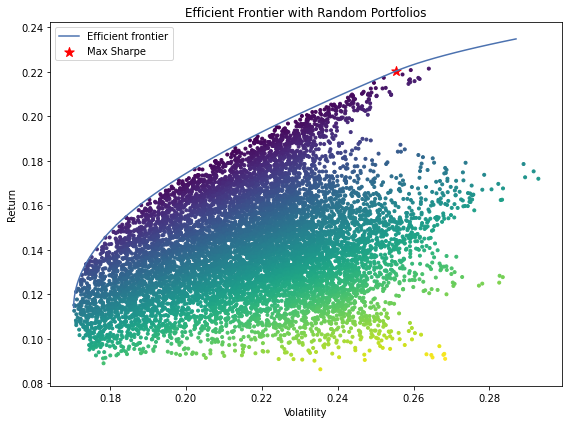

In [ ]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier (mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.04)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

  
    

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

In [ ]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.04)
weights = ef.clean_weights()

In [ ]:
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']
weights_df

,weights
AAPL,0.74996
AXP,0.00000
BAC,0.25004
CVX,0.00000
KO,0.00000


In [ ]:
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 22.04%
Annual volatility: 25.53%
Sharpe ratio: 0.71


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



 **The optimal portfolio, i.e. the one with the best risk-return combination maximizing the sharpe ratio has the following weighting of stocks. 
Although its volatility is striking, it makes sense if we take into account the correlation previously analyzed.**

#Sortino Portfolio Optimization

**We will now use the Sortino Ratio.
This ratio is a refinement of the Sharpe ratio, but it only penalizes returns, which have downside risks.
It recognizes the difference between upside and downside risks. More specifically, it provides an accurate rate of return, given the probability of downside risk, whereas the Sharpe Ratio treats upside and downside risks equally**

**We don't have to worry about complex formulas. PyPortfolioOpt takes care of calculating the semi-variance for us easily.**

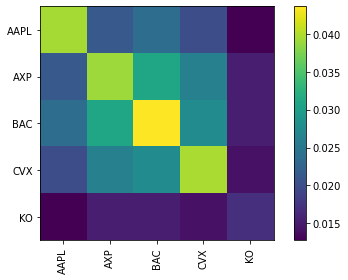

In [ ]:
returns = expected_returns.returns_from_prices(stocks_df)
returns = returns.dropna()
semicov = risk_models.semicovariance(stocks_df, benchmark=0)
plotting.plot_covariance(semicov);

In [ ]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.18)
es.portfolio_performance(verbose=True);

Expected annual return: 18.0%
Annual semi-deviation: 14.5%
Sortino Ratio: 1.11


In [ ]:
weightssortino = es.clean_weights()
weightssortino_df = pd.DataFrame.from_dict(weightssortino, orient = 'index')
weightssortino_df.columns = ['weightssortino']
weightssortino_df

,weightssortino
AAPL,0.51021
AXP,0.00000
BAC,0.19208
CVX,0.00000
KO,0.29771


**Sortino's ratio generates a portfolio with higher yield and lower volatility. This is achieved by weighting only positive volatility and penalizing negative volatility.**

#CVaR optimization

The CVaR quantifies the average loss in the worst 5% of a time frame ( Days in this case.)

First we will calculate the CVaR of our previous calculated portfolios.

In [ ]:
returns = expected_returns.returns_from_prices(stocks_df).dropna()
list1 = mu.index.tolist()

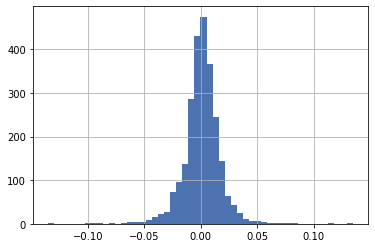

In [ ]:
# Compute CVaR for MaxSharpe
portfolio_rets = (returns[list1] * weights).sum(axis=1)
portfolio_rets.hist(bins=50);

In [ ]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.42%
CVaR: -3.75%


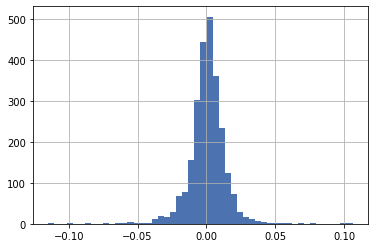

In [ ]:
# Compute CVaR for Sortino
portfolio_rets = (returns[list1] * weightssortino).sum(axis=1)
portfolio_rets.hist(bins=50);

In [ ]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -1.98%
CVaR: -3.08%


**The CVaR value tells us that our average loss will be 3.04% for the sharpe-optimized portfolio and 3.59% for the Sortino-optimized portfolio.**

We can calculate the portfolio that minimizes the CVaR very easily




In [ ]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns[list1])
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 11.2%
Conditional Value at Risk: 2.56%


In [ ]:
weightsVAR = ec.clean_weights()
weightsVARdf = pd.DataFrame.from_dict(weightsVAR, orient = 'index')
weightsVARdf.columns = ['weightsVAR']
weightsVARdf

,weightsVAR
AAPL,0.14481
AXP,0.00000
BAC,0.03776
CVX,0.14853
KO,0.66890


In [ ]:
ec = EfficientCVaR(mu, returns[list])
ec.efficient_risk(target_cvar=0.05)
ec.portfolio_performance(verbose=True);

Expected annual return: 23.5%
Conditional Value at Risk: 4.97%


In [ ]:
weightsVAR2 = ec.clean_weights()
weightsVAR2 = pd.DataFrame.from_dict(weightsVAR2, orient = 'index')
weightsVAR2.columns = ['weightsVAR']
weightsVAR2

,weightsVAR
AAPL,1.0
AXP,0.0
BAC,0.0
CVX,0.0
KO,0.0


**The portfolio that minimizes our average loss in 95% of the cases to 2.56% has a return of 12.5%. If we would like to set a constraint that limits the CVaR to a higher level, in this example 5%, because we are less risk averse, we can observe that the portfolio is recalculated. For this example, placing 100% of the capital in BAC meets these optimization requirements**. 

#Global-minimum variance (GMV) portfolios

 **Finally, we will calculate a portfolio that minimizes volatility as much as possible.
There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios**. 

In [ ]:
S = risk_models.CovarianceShrinkage(stocks_df).ledoit_wolf()

ef = EfficientFrontier(None, S, weight_bounds=(0, None))
ef.min_volatility()
ef.portfolio_performance(verbose=True);



Annual volatility: 17.0%


In [ ]:
weights_minvol = ef.clean_weights()
weights_minvoldf = pd.DataFrame.from_dict(weights_minvol, orient = 'index')
weights_minvoldf.columns = ['weights_minvol']
weights_minvoldf

,weights_minvol
AAPL,0.16379
AXP,0.00000
BAC,0.02873
CVX,0.10185
KO,0.70562


**It is not surprising that a lower volatility portfolio is weighted mostly to Coca-Cola. A very stable and dividend paying company**.

#Optimized portfolio creation

**We will create a table for each portfolio combination and then plot them on a time series to see their evolution.**

In [ ]:
stocks_df['Optimized Portfolio'] = 0

for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AAPL,AXP,BAC,CVX,KO,Optimized Portfolio
Date,,,,,,
2012-08-27,20.692650,49.757397,6.927107,73.821030,27.884924,17.250714
2012-08-28,20.665697,49.878716,6.832685,74.230690,27.760729,17.206891
2012-08-29,20.624969,49.757397,6.867021,73.867264,27.366232,17.184932
2012-08-30,20.330971,49.540760,6.789766,73.292473,27.132467,16.945128
2012-08-31,20.372927,50.519970,6.858437,74.105133,27.322399,16.993764


In [ ]:
stocks_df['Sortino Portfolio'] = 0

for ticker, weight in weightssortino.items():
    stocks_df['Sortino Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AAPL,AXP,BAC,CVX,KO,Optimized Portfolio,Sortino Portfolio
Date,,,,,,,
2012-08-27,20.692650,49.757397,6.927107,73.821030,27.884924,17.250714,20.189776
2012-08-28,20.665697,49.878716,6.832685,74.230690,27.760729,17.206891,20.120914
2012-08-29,20.624969,49.757397,6.867021,73.867264,27.366232,17.184932,19.989284
2012-08-30,20.330971,49.540760,6.789766,73.292473,27.132467,16.945128,19.754850
2012-08-31,20.372927,50.519970,6.858437,74.105133,27.322399,16.993764,19.845991


In [ ]:
stocks_df['CVaR Portfolio'] = 0

for ticker, weight in weightsVAR.items():
    stocks_df['CVaR Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AAPL,AXP,BAC,CVX,KO,Optimized Portfolio,Sortino Portfolio,CVaR Portfolio
Date,,,,,,,,
2012-08-27,20.692650,49.757397,6.927107,73.821030,27.884924,17.250714,20.189776,32.874933
2012-08-28,20.665697,49.878716,6.832685,74.230690,27.760729,17.206891,20.120914,32.845238
2012-08-29,20.624969,49.757397,6.867021,73.867264,27.366232,17.184932,19.989284,32.522778
2012-08-30,20.330971,49.540760,6.789766,73.292473,27.132467,16.945128,19.754850,32.235548
2012-08-31,20.372927,50.519970,6.858437,74.105133,27.322399,16.993764,19.845991,32.491966


In [ ]:
stocks_df['Min_Vol Portfolio'] = 0

for ticker, weight in weights_minvol.items():
    stocks_df['Min_Vol Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AAPL,AXP,BAC,CVX,KO,Optimized Portfolio,Sortino Portfolio,CVaR Portfolio,Min_Vol Portfolio
Date,,,,,,,,,
2012-08-27,20.692650,49.757397,6.927107,73.821030,27.884924,17.250714,20.189776,32.874933,30.783097
2012-08-28,20.665697,49.878716,6.832685,74.230690,27.760729,17.206891,20.120914,32.845238,30.730059
2012-08-29,20.624969,49.757397,6.867021,73.867264,27.366232,17.184932,19.989284,32.522778,30.408995
2012-08-30,20.330971,49.540760,6.789766,73.292473,27.132467,16.945128,19.754850,32.235548,30.135130
2012-08-31,20.372927,50.519970,6.858437,74.105133,27.322399,16.993764,19.845991,32.491966,30.360764


**Download SPY and Berkshire Hathaway Inc. (BRK-A) data**.

In [ ]:
#Get SPY Data. Calculate Cummulative returns and compare.

# SPY
stock_list = ['SPY']

# Timeframe
panel_data = yf.download(stock_list, period='max')
SPY = panel_data[['Adj Close']]



[*********************100%***********************]  1 of 1 completed


In [ ]:
#Get BRK Data. Calculate Cummulative returns and compare.

# BRK
stock_list = ['BRK-A']

# Timeframe
panel_data = yf.download(stock_list, period= 'max')
Warren = panel_data[['Adj Close']]
Warren = Warren.rename(columns={"Adj Close": "Warren Buffet"})


[*********************100%***********************]  1 of 1 completed


In [ ]:
df= stocks_df[['Optimized Portfolio','Sortino Portfolio','CVaR Portfolio','Min_Vol Portfolio']]
df = df.join(SPY, on='Date', how='left',)
df = df.join(Warren, on='Date', how='left',)
df = df.rename(columns={"Adj Close": "SPY"})

#Findings and Comments

In [ ]:
daily_returns = df.pct_change().dropna()   
fig_cum_returns = plot_cum_returns(df, 'Cumulative Returns of Optimized Portfolios Starting with $100 VS SP500')
fig_cum_returns.show()

Ken Fisher stated that "Time in the market beats market timing, almost every time".

From 1965 to the end of 2021, Berkshire shares have generated a compound annual return of 20.1% versus 10.5% for the S&P 500. That's incredible!!!!! 
But if we restrict the time frame to 30 years as we do in our example , we see that that return is down to 14% which is still better than the SPY which is around 9-10%. 
Lawrence Cunningham believes that this narrowing of the return gap is because the SP500 has incorporated technology companies, something that with the exception of Apple Buffett has always been reluctant to do as it goes against his philosophy of "Understand the business in which you invest".
Coincidentally, 35% of the SP500 returns are generated by the FAANGs. What banks were 20 years ago are today's tech companies.However, BKR continues to beat the market and with the economic cycle changing, perhaps that gap can return.

 **Back to portfolio analysis.  Sortino's portfolio beat the market and all other methodologies tested. The Sharpe portfolio also had good returns and beat the market. On the other hand, the VaR-minimizing portfolio was on par with the SP500. Similar case for the volatility minimized portfolio. Although the gap is positive for the latter two, it does not justify a management making it more convenient (for this combination of assets) to buy an ETF that replicates the SP500.
It is demonstrated that using these tools that python has makes it easy and fast to do the calculation allowing us to focus on what really matters, the analysis of theoretical portfolios and how to implement them in the real world. Something not so easy if we take into account that all the optimized ones in this example were beaten by buffet** .
